Notebook to automate regression analysis techniques in order to create a system that selects the best model iteratively

In [1]:
import pandas as pd

In [2]:
def load_data(data_dir, file_name):
    return pd.read_csv(data_dir + file_name)

In [3]:
def select_initial_feature(df):
    #create bivariate models using best R2
    #select best feature based on highest univar R2
    return initial_feature_name

In [4]:
def rank_all_features(df, initial_feature_name, method):
    #create feature ranking list with one of multiple methods e.g. Shapiro, Lasso, Ridge, etc.
    #force the initial_feature_name into position 1 in list
    return ranked_features_list

In [5]:
def select_next_best_feature(df, ranked_features_list, number_of_features):
    #create n models with initial feature and n next best features based on parameter 'number of features'
    #select the best model in terms of RMSE
    #return the features used by best model, and model type
    return best_features, model_type

Building Simple Scalable Solution with Spark

In [6]:
import findspark
findspark.init()

In [7]:
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD, LinearRegressionModel
from pyspark.sql import SparkSession

In [8]:
spark = SparkSession.builder.master("local").appName("Regression Scalability")\
    .config("spark.some.config.option", "some-value")\
    .getOrCreate()

In [9]:
#spark.stop()

In [10]:
#sc = spark.sparkContext

Applying data transformations from regressionDiagnostics nb - these might end up changing

In [11]:
import pandas as pd
import numpy as np
from itertools import combinations

In [12]:
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error
from sklearn.model_selection import KFold,cross_val_score, cross_val_predict

In [13]:
listings = pd.read_csv('listings_augmented_2018-05-06_V1.csv',low_memory=False)

listings = listings.drop(columns=['listing_id','id','scrape_id','host_id',
                                  'zipcode','has_availability','license',
                                  'Unnamed: 0', 'thumbnail_url', 'medium_url',
                                  'picture_url', 'xl_picture_url', 'host_url',
                                  'host_name', 'host_thumbnail_url', 'host_picture_url',
                                  'price_x', 'amenities', 'amenities_set', 'bed_type'
                                 ])

y = listings['price_y'].fillna(listings['price_y'].mean())

X = listings.copy()
#NB: not dropping the price in this nb because it is needed by Spark's ML methods
#X = X.drop(columns='price_y')

X_num = X.select_dtypes(include=['int64','float64'])
X_num = X_num.replace([np.inf, -np.inf], np.nan)
X_num = X_num.fillna(X_num.mean())
X_1 = X_num[X_num.columns.drop(X_num[list(X_num.filter(regex='Topic'))])]
data_scaled = pd.DataFrame(preprocessing.scale(X_1),columns = X_1.columns) 

In [14]:
R2s = []
for col in X_1.columns:
    linear_regression = linear_model.LinearRegression(normalize=False, fit_intercept=True)
    regression_results = linear_regression.fit(data_scaled[col].values.reshape(-1, 1),y)
    #scores = cross_val_score(regression_results, data_scaled[col].values.reshape(-1, 1), y, cv=6)
    predictions = cross_val_predict(regression_results, data_scaled[col].values.reshape(-1, 1), y, cv=6)
    #accuracy = metrics.r2_score(y, predictions)
    R2s.append((col, r2_score(y, predictions)))

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [15]:
uni_r2 = pd.DataFrame(R2s, columns = ['col','R2']).sort_values(by='R2', ascending=False)
pos_uni_r2 = uni_r2[uni_r2['R2']>0]

In [16]:
candidates_050918 = ['availability_30','accommodates','calculated_host_listings_count','has"Cable TV"',\
              'distance from ocean','has"Indoor Fireplace"','hasDryer',\
              'has"Hot Tub"','hasDoorman']
cands_050918 = ['price_y']
for i in candidates:
    cands.append(i)

#candidates.remove("price_y")

Insights 05 - 09 - 18: the best features are 'availability_30','accommodates','calculated_host_listings_count','has"Cable TV"'

In [37]:
candidates_051018 = ['availability_30','accommodates','calculated_host_listings_count','has"Cable TV"','bathrooms'
,'bedrooms'
,'beds'
,'square_feet'
,'weekly_price'
,'monthly_price'
,'security_deposit'
,'cleaning_fee'
,'guests_included'
,'extra_people'
,'minimum_nights'
,'maximum_nights']

In [31]:
# must look at listings['host_response_rate'] - make sure vars are ok
# must write to db or log file
# must label encode cat features

In [57]:
from itertools import chain, combinations

candidates = candidates_051018
min_range = len(candidates)-4

def all_subsets(ss):
    return chain(*map(lambda x: combinations(ss, x), range(min_range, len(ss)+1)))
combos = []

for subset in all_subsets(candidates):
    combos.append(subset)
    
cands_051018_V1 = ['price_y']
for i in candidates:
    cands_051018_V1.append(i)

Trying to select important features by doing a RFECV instead of looking at univariate linear regressions first

In [65]:
from sklearn.feature_selection import RFECV

estimator2 = linear_model.LinearRegression()
selector2 = RFECV(estimator2, step=3, cv=5)
selector2 = selector2.fit(data_scaled, y)

In [66]:
for i,k in zip(data_scaled.columns, selector2.ranking_):
    print i,k

host_response_rate 17
host_acceptance_rate 16
host_listings_count 1
host_total_listings_count 1
neighbourhood_group_cleansed 1
latitude 1
longitude 3
accommodates 1
bathrooms 1
bedrooms 1
beds 1
square_feet 15
weekly_price 1
monthly_price 1
security_deposit 1
cleaning_fee 1
guests_included 1
extra_people 1
minimum_nights 1
maximum_nights 1
availability_30 1
availability_60 1
availability_90 1
availability_365 1
number_of_reviews 1
review_scores_rating 1
review_scores_accuracy 1
review_scores_cleanliness 1
review_scores_checkin 1
review_scores_communication 1
review_scores_location 1
review_scores_value 14
calculated_host_listings_count 1
reviews_per_month 1
price_y 1
space_TextLength 1
space_TextWordsPerc 6
space_TextPuncPerc 1
space_TextDigitsPerc 1
description_TextLength 1
description_TextWordsPerc 12
description_TextPuncPerc 1
description_TextDigitsPerc 1
neighborhood_overview_TextLength 1
neighborhood_overview_TextWordsPerc 16
neighborhood_overview_TextPuncPerc 1
neighborhood_overv

In [59]:
outputlist = [xs + ('price_y',) for xs in combos]

In [60]:
sparkDF = spark.createDataFrame(data_scaled[cands_051018_V1])

In [69]:
#Had loaded spark df from file - but prefer to do data manipulation in pandas and load ultimate df
#df = spark.read.format('csv').options(header='true', inferSchema='true').load("listings_augmented_2018-05-06_V1.csv")

In [62]:
#sparkDF.printSchema()

In [43]:
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor, DecisionTreeRegressor
from pyspark.ml.linalg import Vectors
from pyspark.sql import Row
from pyspark.ml.evaluation import RegressionEvaluator
spark.version

u'2.3.0'

In [44]:
def split_data(data, train_size):
    (trainingData, testData) = data.randomSplit([train_size, 1-train_size])
    return trainingData, testData

In [45]:
def create_linear_regression(data):
    lr = LinearRegression(maxIter=10, regParam=0, solver = 'normal', elasticNetParam=0, fitIntercept=True)
    #lr.setFitIntercept(True)
    lrModel = lr.fit(data)
    return lrModel

In [46]:
def create_random_forest_regression(data):
    rf = RandomForestRegressor()
    rfModel = rf.fit(data)
    featureImportances = rfModel.featureImportances
    return rfModel,featureImportances

In [47]:
def create_decision_tree_regression(data):
    dtr = DecisionTreeRegressor(maxDepth=2, varianceCol="variance")
    dtrModel = dtr.fit(data)
    featureImportances = dtrModel.featureImportances
    return dtrModel,featureImportances

In [48]:
def create_grad_boosted_regression(data):
    gbt = GBTRegressor(maxIter=10)
    gbtModel = gbt.fit(data)
    return gbtModel 

In [49]:
#Not sure if I'll do this one
def create_non_linear_regression(data):
    return nlrModel

In [50]:
def print_model_results(model, predictions):
    # Print the coefficients and intercept for linear regression
    print("\n")
    print("Coefficients: %s" % str(model.coefficients))
    print("Intercept: %s" % str(model.intercept))
    # Summarize the model over the training set and print out some metrics
    summary = model.summary
    print("numIterations: %d" % summary.totalIterations)
    print("objectiveHistory: %s" % str(summary.objectiveHistory))
    summary.residuals.show()
    print("Root Mean Squared Error (RMSE) on training data: %f" % summary.rootMeanSquaredError)
    print("r2: %f" % summary.r2)
    # Select (prediction, true label) and compute test error
    evaluator = RegressionEvaluator(
        labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)
    print("\n")

In [64]:
def save_model_results(model, DTRfeatureImportances,RFRfeatureImportances, model_features, model_type, predictions):
    
    dictionary = dict()
    
    #model ID & features
    model_features = list(model_features)
    dictionary['model_id'] = '-'.join(model_features)
    dictionary['model_type'] = str(model_type)
    dictionary['features'] = model_features
    dictionary['DTRfeatureImportances'] = DTRfeatureImportances
    dictionary['RFRfeatureImportances'] = RFRfeatureImportances
    
    #Training Data Summary Metrics
    summary = model.summary
    
    dictionary['coefficientStandardErrors'] = summary.coefficientStandardErrors
    dictionary['degreesOfFreedom'] = summary.degreesOfFreedom
    dictionary['devianceResiduals'] = summary.devianceResiduals
    dictionary['explainedVariance'] = summary.explainedVariance
    dictionary['meanAbsoluteError'] = summary.meanAbsoluteError
    dictionary['meanSquaredError'] = summary.meanSquaredError
    dictionary['pValues'] = summary.pValues
    dictionary['r2'] = summary.r2
    dictionary['residuals'] = summary.residuals
    dictionary['rootMeanSquaredError'] = summary.rootMeanSquaredError
    dictionary['tValues'] = summary.tValues
    
    #Test Data Metrics
    evaluator = RegressionEvaluator(
        labelCol="label", predictionCol="prediction")
    rmse = evaluator.evaluate(predictions)
    
    r2_test = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
    mae_test = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
    rmse_test = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
    
    dictionary['r2_test'] = r2_test
    dictionary['mae_test'] = mae_test
    dictionary['rmse_test'] = rmse_test
    
    return dictionary

Modeling: linear regression, gradient boosted tree regression, random forest regression

In [52]:
def compute_linear_regression(outputlist):
    
    models_dict = []
    
    for i in outputlist:
        #preparing data
        new = sparkDF.select(list(i))
        data = new.rdd.map(lambda x:(Vectors.dense(x[0:-1]), x[-1])).toDF(["features", "label"])
        trainingData, testData = split_data(data, 0.72)
        #modeling
        lrModel = create_linear_regression(trainingData)
        predictions = lrModel.transform(testData)
        print 'Model Results for Features: ',i
        print_model_results(lrModel, predictions)
        
        #feature importances with dec tree reg & random forest regressor
        dtrModel, DTRfeatureImportances = create_decision_tree_regression(data)
        rfModel, RFRfeatureImportances = create_random_forest_regression(data)
        
        #append model to dictionary 
        temp_dict = save_model_results(lrModel, DTRfeatureImportances, 
                                       RFRfeatureImportances, i, linear_regression, predictions)
        models_dict.append(temp_dict)
       
        
    return models_dict
        #saving models
        #enter code here

In [65]:
%%time
dic = compute_linear_regression(outputlist)

Model Results for Features:  ('availability_30', 'accommodates', 'calculated_host_listings_count', 'has"Cable TV"', 'bathrooms', 'bedrooms', 'beds', 'square_feet', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'price_y')


Coefficients: [0.05909519276490275,0.5501016857980773,0.1098699645009644,0.05883505222222153,0.061517003607815084,0.17081896438683722,-0.08077029574213736,0.007403252627265706,0.0,0.0,0.0,0.0]
Intercept: -0.000250498291327
numIterations: 11
objectiveHistory: [0.49999999999999994, 0.2501924365349412, 0.24779693684643056, 0.23749711701844817, 0.23473091778879535, 0.23394079578661103, 0.23362516213509305, 0.2334443777246507, 0.2334385925370715, 0.2334321622396155, 0.2334314600414894]
+--------------------+
|           residuals|
+--------------------+
| -0.0736933021354178|
|-0.19520557181729103|
|-0.18493812452241876|
|-0.18493812452241876|
|-0.13976135642498055|
|-0.06172875698395097|
| 0.08612248406221046|
| 0.09228295243913387|
|  0.1169248259

Py4JJavaError: An error occurred while calling o703.pValues.
: java.lang.UnsupportedOperationException: No p-value available for this LinearRegressionModel
	at org.apache.spark.ml.regression.LinearRegressionSummary.pValues$lzycompute(LinearRegression.scala:1012)
	at org.apache.spark.ml.regression.LinearRegressionSummary.pValues(LinearRegression.scala:1010)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)


In [32]:
def compute_random_forest_regression(outputlist):
    
    models_dict= []
    
    for i in outputlist:
        #preparing data
        new = sparkDF.select(list(i))
        data = new.rdd.map(lambda x:(Vectors.dense(x[0:-1]), x[-1])).toDF(["features", "label"])
        trainingData, testData = split_data(data, 0.72)
        #modeling
        rfModel = create_linear_regression(trainingData)
        predictions = rfModel.transform(testData)
        print 'Model Results for Features: ',i
        print_model_results(rfModel, predictions)
        temp_dict = save_model_results(lrModel, i, linear_regression, predictions)
        models_dict.append(temp_dict)

In [33]:
compute_random_forest_regression(outputlist)

Model Results for Features:  ('accommodates', 'calculated_host_listings_count', 'price_y')


Coefficients: [0.6511541609091435,0.11866271008090529]
Intercept: -0.0116860704607
numIterations: 1
objectiveHistory: [0.0]
+--------------------+
|           residuals|
+--------------------+
|-0.23565605668194567|
|-0.31222837605737275|
|   -0.28347952363173|
| -0.2826581278481404|
| -0.2814260341727557|
|-0.26910509741890887|
| -0.2608911395830109|
|-0.25147931289604464|
|-0.25062369228813863|
|-0.25062369228813863|
|-0.25062369228813863|
|-0.25062369228813863|
| -0.2445487859720059|
| -0.2437787274248906|
|-0.22844600613121457|
|-0.22803530823941975|
|-0.22064274618711144|
| -0.2198213504035218|
| -0.2198213504035218|
| -0.2198213504035218|
+--------------------+
only showing top 20 rows

Root Mean Squared Error (RMSE) on training data: 0.695583
r2: 0.499216
Root Mean Squared Error (RMSE) on test data = 0.727469


Model Results for Features:  ('accommodates', 'has"Cable TV"', 'price_y')


C

Root Mean Squared Error (RMSE) on test data = 0.692453


Model Results for Features:  ('calculated_host_listings_count', 'has"Cable TV"', 'distance from ocean', 'price_y')


Coefficients: [0.2394855195386699,0.1881375477866578,-0.12508651189448355]
Intercept: 0.00145044729136
numIterations: 1
objectiveHistory: [0.0]
+-------------------+
|          residuals|
+-------------------+
|-1.1569054376902144|
|-0.9268378286986082|
|-0.8941787900948354|
|-0.8676946996013503|
|-0.8643775243214684|
|-0.8643775243214684|
|-0.8492563746690202|
|-0.8397356508137748|
|-0.8351152995310822|
|-0.8335751824368514|
|-0.8335751824368514|
|-0.8335751824368514|
|-0.8156538198858015|
| -0.796612372175311|
|-0.7767480047558437|
|-0.7719704986676175|
|-0.7625795407759659|
|-0.7588795033666552|
|-0.7588331142975518|
|-0.7473286251599239|
+-------------------+
only showing top 20 rows

Root Mean Squared Error (RMSE) on training data: 0.922296
r2: 0.150641
Root Mean Squared Error (RMSE) on test data = 0.904847




In [34]:
#Will see if going to do this, I need to edit the model evalaution method or create a new one
def compute_grad_boosted_regression(outputlist):
    for i in outputlist:
        #preparing data
        new = sparkDF.select(list(i))
        data = new.rdd.map(lambda x:(Vectors.dense(x[0:-1]), x[-1])).toDF(["features", "label"])
        trainingData, testData = split_data(data, 0.72)
        #modeling
        gbtModel = create_grad_boosted_regression(trainingData)
        predictions = gbtModel.transform(testData)
        print 'Model Results for Features: ',i
        #Model results will probably have to change
        print_model_results(gbtModel, predictions)

In [35]:
#compute_grad_boosted_regression(outputlist)

In [36]:
#Additional Modeling Techniques:
#Do lasso lars and or ridge for feature selection by just modifying lienar model parameter (see docs)

In [38]:
#Plot Results of all models to see what works and what doesnt

In [82]:
models_df = pd.DataFrame.from_dict(dic)

In [85]:
len(models_df)

502

In [86]:
models_df.columns

Index([u'DTRfeatureImportances', u'RFRfeatureImportances',
       u'coefficientStandardErrors', u'degreesOfFreedom', u'devianceResiduals',
       u'explainedVariance', u'features', u'mae_test', u'meanAbsoluteError',
       u'meanSquaredError', u'model_id', u'model_type', u'pValues', u'r2',
       u'r2_test', u'residuals', u'rmse_test', u'rootMeanSquaredError',
       u'tValues'],
      dtype='object')

In [93]:
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

In [106]:
#Some basic data transformations on models_df to better visualize things
models_df['numOfFeatures'] = models_df['features'].apply(lambda x: len(x)-1)

In [97]:
models_df.features

0               [availability_30, accommodates, price_y]
1      [availability_30, calculated_host_listings_cou...
2              [availability_30, has"Cable TV", price_y]
3        [availability_30, distance from ocean, price_y]
4      [availability_30, has"Indoor Fireplace", price_y]
5                   [availability_30, hasDryer, price_y]
6               [availability_30, has"Hot Tub", price_y]
7                 [availability_30, hasDoorman, price_y]
8      [accommodates, calculated_host_listings_count,...
9                 [accommodates, has"Cable TV", price_y]
10          [accommodates, distance from ocean, price_y]
11        [accommodates, has"Indoor Fireplace", price_y]
12                     [accommodates, hasDryer, price_y]
13                 [accommodates, has"Hot Tub", price_y]
14                   [accommodates, hasDoorman, price_y]
15     [calculated_host_listings_count, has"Cable TV"...
16     [calculated_host_listings_count, distance from...
17     [calculated_host_listing

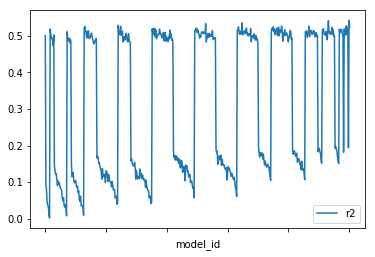

In [101]:
models_df.plot(x='model_id',y='r2')
plt.show()

/Users/pauldefusco/anaconda2/envs/py27/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


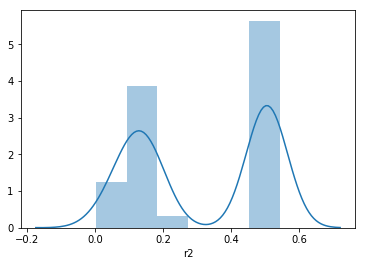

In [100]:
sb.distplot(models_df['r2'])

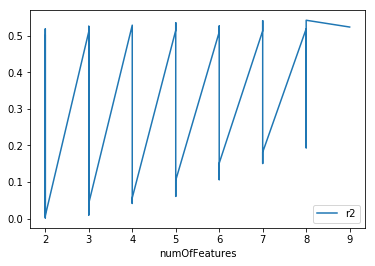

In [107]:
models_df.plot(x='numOfFeatures',y='r2')
plt.show()

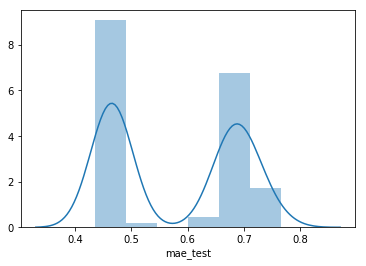

In [110]:
sb.distplot(models_df['mae_test'])

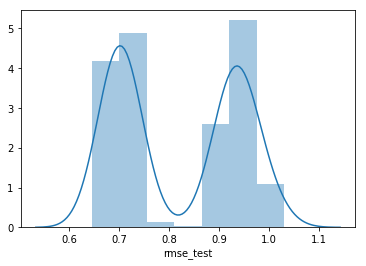

In [111]:
sb.distplot(models_df['rmse_test'])

In [23]:
models_df.nlargest(5, 'r2')

NameError: name 'models_df' is not defined

<Figure size 432x288 with 0 Axes>

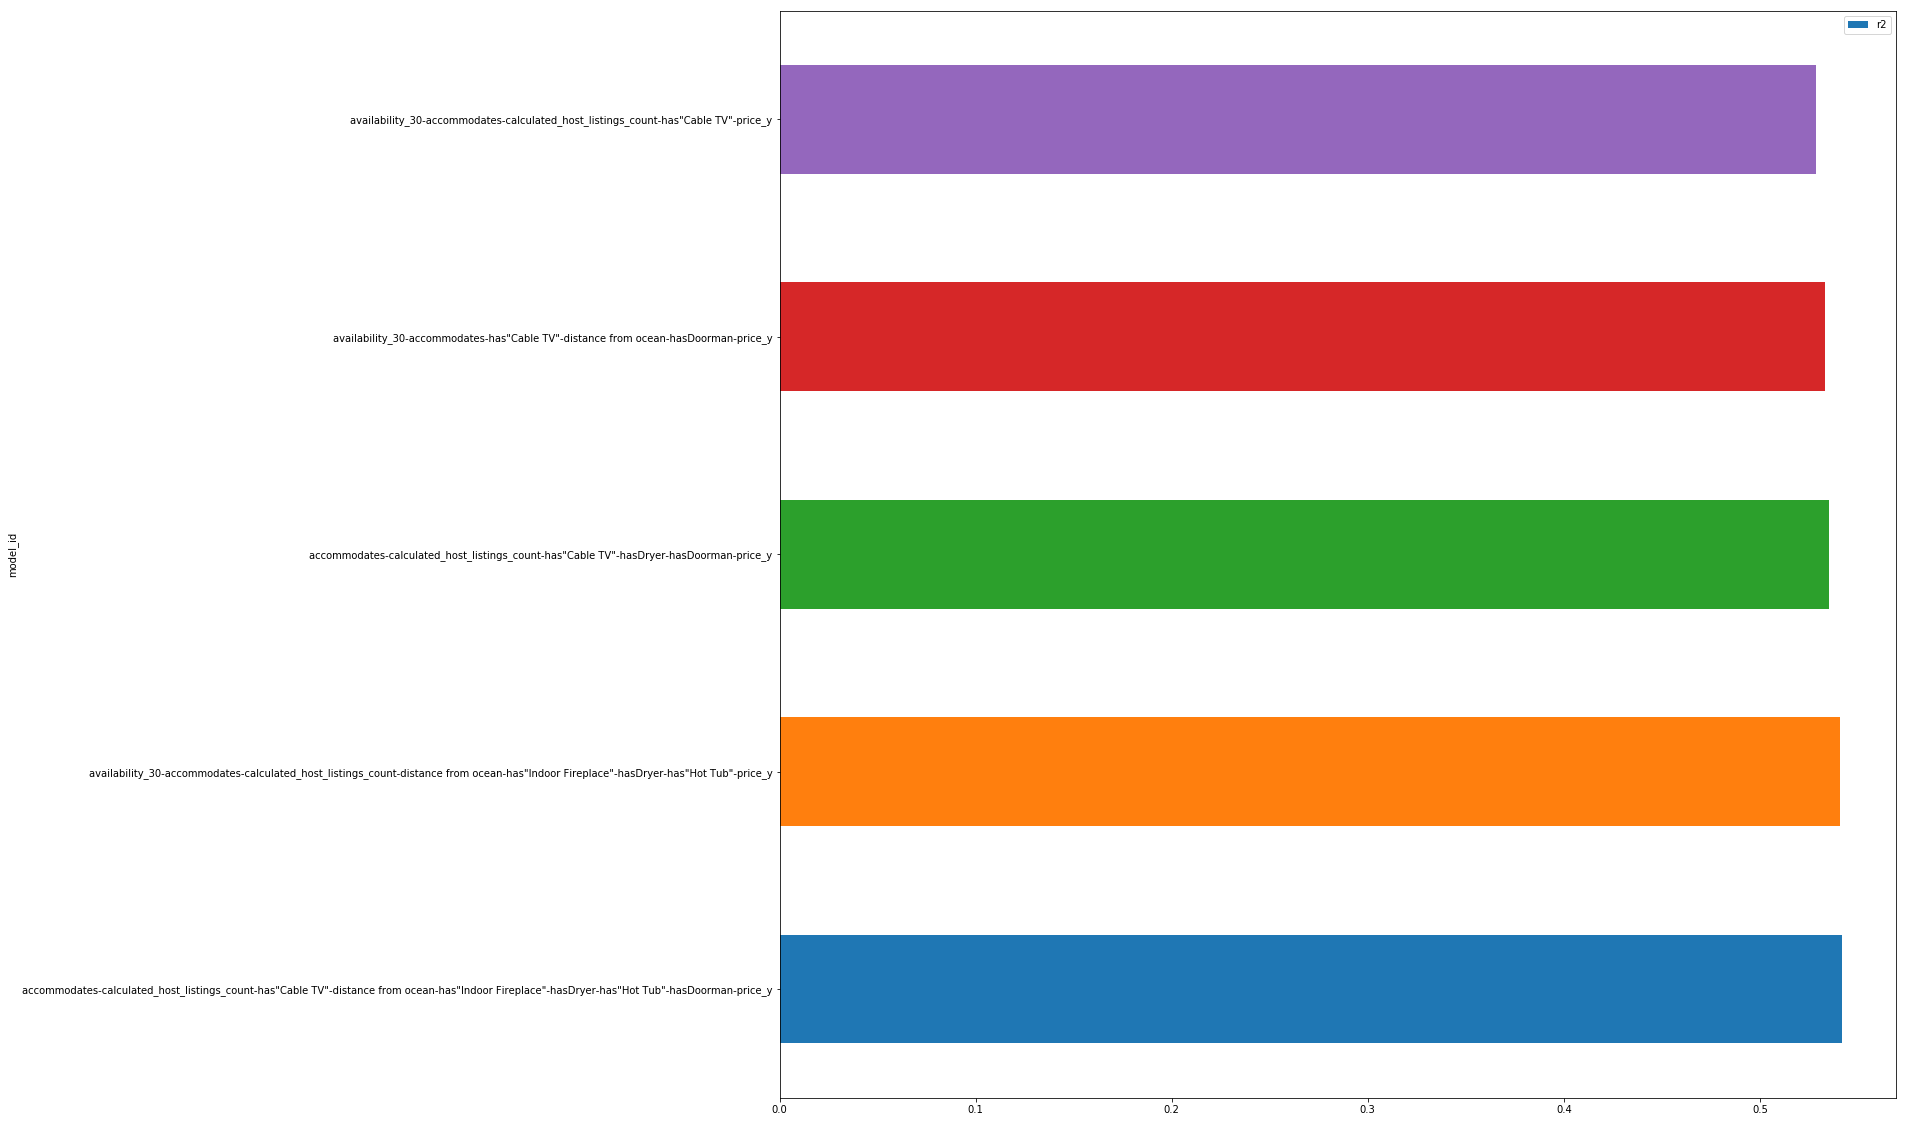

In [118]:
plt.figure()
models_df.nlargest(5, 'r2').plot(x='model_id',y='r2', kind='barh', figsize=(20,20))
plt.show()

insight: must use more features..

In [ ]:
#tomorrow will focus on adding more features and only starting from highest n and working way down to a few at a time

In [39]:
#plot performance of the jobs or use spark UI (maybe)

In [119]:
spark.stop()